In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support
)
from imblearn.over_sampling import RandomOverSampler
from transformers import pipeline

In [13]:
# ==============================
# 1. Load Dataset
# ==============================
df = pd.read_csv("comments.csv")   # dataset (expects "Comments" column)
df = df.dropna(subset=["Comments"])  # drop empty rows

print("Sample data:\n", df.head())

Sample data:
                                             Comments
0  bat walang gumagalaw Kay Romualdez eh siya nga...
1                               kunyari hindi alam..
2  question before mag release nang full payment ...
3              di ako naniniwala na di nila alam yan
4          Sana kampi ka sa kabutihan Vince Dizon 🙏🙏


In [14]:
# ==============================
# 2. Generate Pseudo-Labels with Multilingual Model
# ==============================
sentiment_model = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment"
)

def get_sentiment_with_score(text):
    try:
        r = sentiment_model(str(text))[0]
        label = r['label'].lower()
        score = r['score']
        
        # Map star ratings to positive/negative
        if label in ['1 star', '2 stars']:
            return 'negative', score
        elif label in ['4 stars', '5 stars']:
            return 'positive', score
        else:  # 3 stars = neutral
            return 'neutral', score
    except:
        return "neutral", 0.0

print("Processing ALL comments with multilingual sentiment analysis...")
print("="*70)

# Apply to all comments (not just first 10)
tmp = df['Comments'].apply(
    lambda t: pd.Series(get_sentiment_with_score(t), index=['Sentiment','Score'])
)
df = pd.concat([df, tmp], axis=1)

print(f"Processed {len(df)} comments")
print("\nAll sentiment labels found:")
print(df['Sentiment'].value_counts())
print(f"\nScore distribution:")
print(df['Score'].describe())

# Show some examples
print(f"\n📝 Sample results:")
sample_results = df[['Comments', 'Sentiment', 'Score']].head(10)
for idx, row in sample_results.iterrows():
    emoji = "😠" if row['Sentiment'] == 'negative' else "😊" if row['Sentiment'] == 'positive' else "😐"
    print(f"{emoji} {row['Comments'][:60]}... → {row['Sentiment']} ({row['Score']:.3f})")

# Adaptive confidence filtering
print(f"\n{'='*70}")
print("APPLYING CONFIDENCE FILTERING:")

confidence_thresholds = [0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
selected_threshold = 0.25

for threshold in confidence_thresholds:
    filtered_df = df[(df["Sentiment"].isin(["positive", "negative"])) & (df["Score"] >= threshold)]
    
    print(f"\nWith confidence >= {threshold}: {len(filtered_df)} samples")
    print(f"  - Positive: {sum(filtered_df['Sentiment'] == 'positive')}")
    print(f"  - Negative: {sum(filtered_df['Sentiment'] == 'negative')}")
    
    if len(filtered_df) >= 50:  # Need minimum viable dataset
        selected_threshold = threshold
        print(f"Selected threshold: {threshold}")
        break
    else:
        print(f"Too few samples with threshold {threshold}")

# Apply the selected threshold
df = df[(df["Sentiment"].isin(["positive", "negative"])) & (df["Score"] >= selected_threshold)]

print(f"\n🎯 FINAL RESULT:")
print(f"Confidence threshold used: {selected_threshold}")
print(f"Remaining samples: {len(df)}")
print("\nFinal sentiment distribution:")
print(df["Sentiment"].value_counts())

if len(df) < 30:
    print("\nWARNING: Dataset very small. Consider using a different approach.")
else:
    print(f"\nDataset ready for analysis with {len(df)} samples!")
    
    # Show some examples of each class
    if len(df[df['Sentiment'] == 'negative']) > 0:
        print(f"\nSample NEGATIVE comments:")
        for comment in df[df['Sentiment'] == 'negative']['Comments'].head(3):
            print(f"   • {comment}")
    
    if len(df[df['Sentiment'] == 'positive']) > 0:
        print(f"\nSample POSITIVE comments:")
        for comment in df[df['Sentiment'] == 'positive']['Comments'].head(3):
            print(f"   • {comment}")

Device set to use mps:0


Processing ALL comments with multilingual sentiment analysis...
Processed 978 comments

All sentiment labels found:
Sentiment
negative    661
neutral     175
positive    142
Name: count, dtype: int64

Score distribution:
count    978.000000
mean       0.423281
std        0.145744
min        0.213346
25%        0.317706
50%        0.382760
75%        0.491807
max        0.959680
Name: Score, dtype: float64

📝 Sample results:
😠 bat walang gumagalaw Kay Romualdez eh siya nga pinaka suspic... → negative (0.426)
😊 kunyari hindi alam..... → positive (0.353)
😠 question before mag release nang full payment wla man lang i... → negative (0.548)
😐 di ako naniniwala na di nila alam yan... → neutral (0.275)
😊 Sana kampi ka sa kabutihan Vince Dizon 🙏🙏... → positive (0.314)
😠 ano ba talaga kasi ginagawa ng dating sec ng DPWH??... → negative (0.350)
😠 It's actually an insult to animals to say that. 😊 Animals ar... → negative (0.331)
😠 Curious lng talaga ako kung hindi talaga alam ni sec vince o... → n

In [15]:
# ==============================
# 3. Train-Test-Unseen Split (70/20/10)
# ==============================
# Step 1: Hold out 10% unseen
rest_df, unseen_df = train_test_split(
    df, test_size=0.10, stratify=df['Sentiment'], random_state=42
)
# Step 2: From remaining 90%, split 70/20 (relative: 70/90 ≈ 77.8%)
train_df, test_df = train_test_split(
    rest_df, test_size=2/9, stratify=rest_df['Sentiment'], random_state=42
)

print(f"\nTrain: {len(train_df)}, Test: {len(test_df)}, Unseen: {len(unseen_df)}")


Train: 549, Test: 158, Unseen: 79


In [16]:
# ==============================
# 4. TF-IDF Vectorization
# ==============================
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(train_df['Comments'])
y_train = train_df['Sentiment']
X_test = vectorizer.transform(test_df['Comments'])
y_test = test_df['Sentiment']
X_unseen = vectorizer.transform(unseen_df['Comments'])
y_unseen = unseen_df['Sentiment']

In [17]:
# ==============================
# 5. Apply RandomOverSampler (fixes SMOTE issue with sparse)
# ==============================
ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)

print("\nBalanced training distribution:\n", pd.Series(y_train_bal).value_counts())


Balanced training distribution:
 Sentiment
negative    457
positive    457
Name: count, dtype: int64



===== Naive Bayes =====
Accuracy (Test): 0.8354
              precision    recall  f1-score   support

    negative       0.92      0.88      0.90       131
    positive       0.52      0.63      0.57        27

    accuracy                           0.84       158
   macro avg       0.72      0.75      0.73       158
weighted avg       0.85      0.84      0.84       158



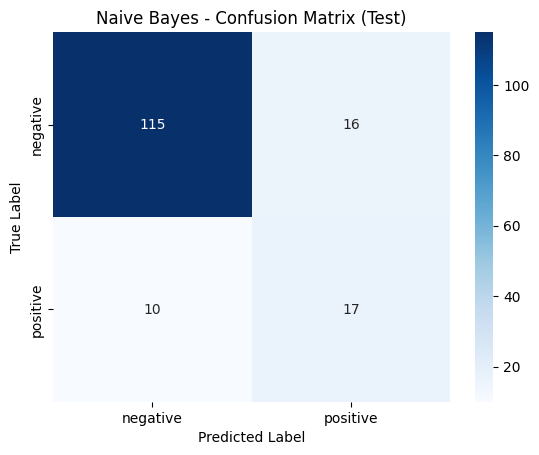


===== Logistic Regression =====
Accuracy (Test): 0.8354
              precision    recall  f1-score   support

    negative       0.88      0.92      0.90       131
    positive       0.52      0.41      0.46        27

    accuracy                           0.84       158
   macro avg       0.70      0.67      0.68       158
weighted avg       0.82      0.84      0.83       158



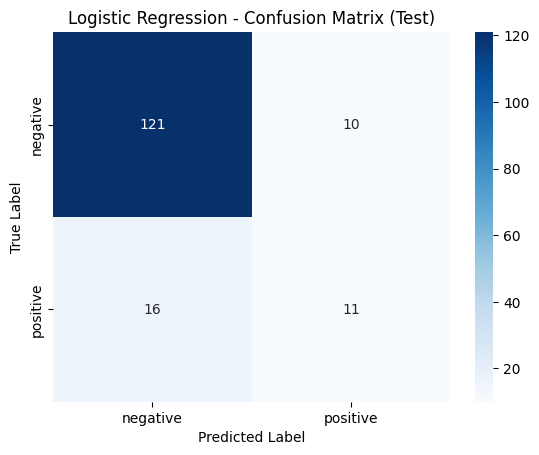


Best Logistic Regression params: {'C': 10}


In [18]:
# ==============================
# 6. Train Models (with Iterative Improvement for LR)
# ==============================
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy (Test): {acc:.4f}")
    print(classification_report(y_test, y_pred))

    results[name] = {"model": model, "test_acc": acc}

    # Confusion Matrix Plot
    cm = confusion_matrix(y_test, y_pred, labels=["negative", "positive"])
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["negative", "positive"],
        yticklabels=["negative", "positive"]
    )
    plt.title(f"{name} - Confusion Matrix (Test)")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

# Iterative Improvement: Hyperparameter tuning for Logistic Regression
param_grid = {"C": [0.01, 0.1, 1, 10]}
grid = GridSearchCV(
    LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    param_grid, cv=3, scoring="f1_macro"
)
grid.fit(X_train_bal, y_train_bal)
print("\nBest Logistic Regression params:", grid.best_params_)
best_lr = grid.best_estimator_

# Update results with best LR
results["Logistic Regression (Tuned)"] = {
    "model": best_lr,
    "test_acc": accuracy_score(y_test, best_lr.predict(X_test))
}


===== Final Evaluation on Unseen Data (Naive Bayes) =====
Accuracy (Unseen): 0.8608
              precision    recall  f1-score   support

    negative       0.92      0.91      0.92        66
    positive       0.57      0.62      0.59        13

    accuracy                           0.86        79
   macro avg       0.75      0.76      0.75        79
weighted avg       0.87      0.86      0.86        79



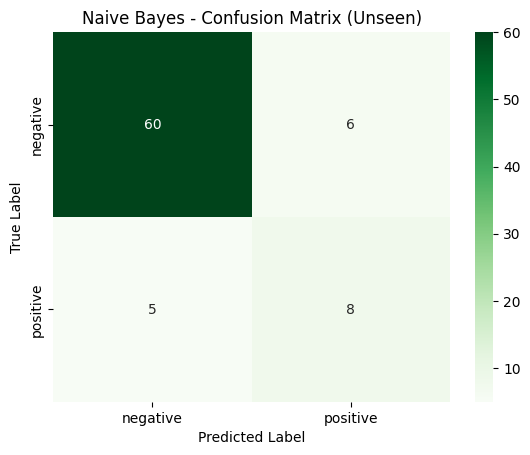


===== Final Evaluation on Unseen Data (Logistic Regression) =====
Accuracy (Unseen): 0.8608
              precision    recall  f1-score   support

    negative       0.90      0.94      0.92        66
    positive       0.60      0.46      0.52        13

    accuracy                           0.86        79
   macro avg       0.75      0.70      0.72        79
weighted avg       0.85      0.86      0.85        79



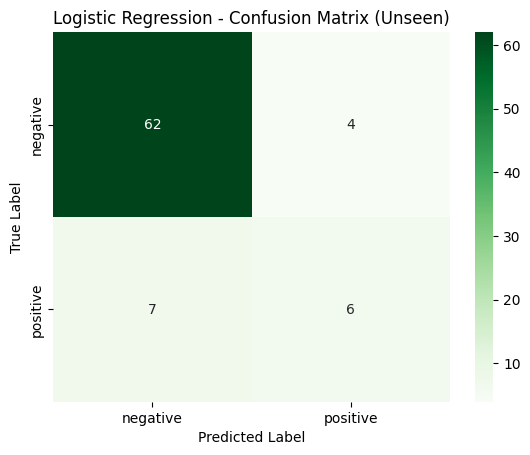


===== Final Evaluation on Unseen Data (Logistic Regression (Tuned)) =====
Accuracy (Unseen): 0.8354
              precision    recall  f1-score   support

    negative       0.88      0.92      0.90        66
    positive       0.50      0.38      0.43        13

    accuracy                           0.84        79
   macro avg       0.69      0.65      0.67        79
weighted avg       0.82      0.84      0.83        79



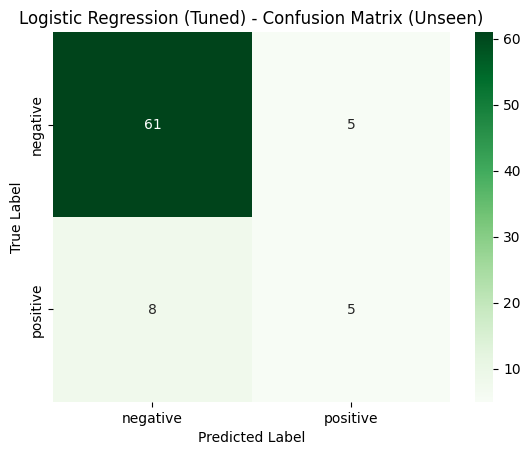

In [19]:
# ==============================
# 7. Evaluate on Unseen Data
# ==============================
for name, res in results.items():
    print(f"\n===== Final Evaluation on Unseen Data ({name}) =====")
    model = res["model"]
    y_pred_unseen = model.predict(X_unseen)
    acc_unseen = accuracy_score(y_unseen, y_pred_unseen)
    print(f"Accuracy (Unseen): {acc_unseen:.4f}")
    print(classification_report(y_unseen, y_pred_unseen))

    cm = confusion_matrix(y_unseen, y_pred_unseen, labels=["negative", "positive"])
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Greens",
        xticklabels=["negative", "positive"],
        yticklabels=["negative", "positive"]
    )
    plt.title(f"{name} - Confusion Matrix (Unseen)")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

In [20]:
# ==============================
# 9. Additional Analysis
# ==============================
print("\n===== ADDITIONAL ANALYSIS =====")
for name, res in results.items():
    model = res['model']
    y_pred = model.predict(X_test)
    p, r, f, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label='positive')
    print(f"{name} -> Precision: {p:.3f}, Recall: {r:.3f}, F1: {f:.3f}")

# Error analysis: show sample false positives/negatives
best_model = results["Logistic Regression (Tuned)"]["model"]
test_df = test_df.copy()
test_df["Pred"] = best_model.predict(X_test)
fn = test_df[(test_df['Sentiment']=='positive') & (test_df['Pred']=='negative')].head(5)
fp = test_df[(test_df['Sentiment']=='negative') & (test_df['Pred']=='positive')].head(5)

print("\nSAMPLE FALSE NEGATIVES:\n", fn['Comments'].tolist())
print("\nSAMPLE FALSE POSITIVES:\n", fp['Comments'].tolist())


===== ADDITIONAL ANALYSIS =====
Naive Bayes -> Precision: 0.515, Recall: 0.630, F1: 0.567
Logistic Regression -> Precision: 0.524, Recall: 0.407, F1: 0.458
Logistic Regression (Tuned) -> Precision: 0.588, Recall: 0.370, F1: 0.455

SAMPLE FALSE NEGATIVES:
 ['Kawawa ang economy ng pilipinas', 'We all know the shortcuts & shortchanging!Time to punish all involved!😡😡', 'As President, you have all the powers at your disposal to address the issue.. If, and only if, you will walk the talk.', 'From the guy who said "ayaw ko ma-impeach si Sara Duterte."\n\nFrom the guy who formed Uniteam to ensure his victory.\n\nSure, sure.', 'don’t worry, they will come back. just ensure you have arrest warrants for them when they come back….and keep it secret.']

SAMPLE FALSE POSITIVES:
 ['Whoa that’s evil', 'walang makukulong sakanila\n nasa pilipinas tayo eh 🥱', 'edit yarn?', 'This guy is crazy hahahaha', 'Tapos sa huli walang makukulong 🤦🏻\u200d♀️🤦🏻\u200d♀️🤦🏻\u200d♀️']


In [21]:
# ==============================
# 8. Top Positive & Negative Comments (Top 10 each)
# ==============================

# Use the tuned Logistic Regression model
best_model = results["Logistic Regression (Tuned)"]["model"]

# Get prediction probabilities for unseen data
probs = best_model.predict_proba(X_unseen)
unseen_df = unseen_df.copy()
unseen_df["Negative Probability"] = probs[:, 0].round(3)
unseen_df["Positive Probability"] = probs[:, 1].round(3)

# Select top 10 rows for each sentiment
top_neg_display = (
    unseen_df.sort_values("Negative Probability", ascending=False)
    .loc[:, ["Comments", "Negative Probability"]]
    .head(10)
    .reset_index(drop=True)
)
top_pos_display = (
    unseen_df.sort_values("Positive Probability", ascending=False)
    .loc[:, ["Comments", "Positive Probability"]]
    .head(10)
    .reset_index(drop=True)
)

# Reset table indices to start from 1
top_neg_display.index += 1
top_pos_display.index += 1

# ==============================
# Display styled tables
# ==============================
print("\n" + "="*80)
print("TOP 10 MOST NEGATIVE COMMENTS")
print("="*80)
display(
    top_neg_display.style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#ffcccc'),
                                     ('color', 'black'),
                                     ('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('border', '1px solid #ddd'),
                                     ('padding', '8px')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f9f9f9')]},
        {'selector': 'tr:hover', 'props': [('background-color', '#f5f5f5')]}
    ])
)

print("\n" + "="*80)
print("TOP 10 MOST POSITIVE COMMENTS")
print("="*80)
display(
    top_pos_display.style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#ccffcc'),
                                     ('color', 'black'),
                                     ('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('border', '1px solid #ddd'),
                                     ('padding', '8px')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f9f9f9')]},
        {'selector': 'tr:hover', 'props': [('background-color', '#f5f5f5')]}
    ])
)


TOP 10 MOST NEGATIVE COMMENTS


,Comments,Negative Probability
1,"TUMBUKIN NA AGAD ANG PINAKA PUNO. Hindi naman KIKILOS yang mga career officials na yan kung ealang basbas ng Isang either appointive or elected official. Alam ng taumbayan yan. Hindi nga lang kumukilos ang PILIPINO dahil ayaw na ma sangkot sa gulo. Pinapatay nyo kasi, tinatapon sa Taal. Pero mag ingat na kayo mula ngayon. Darating dito ang Indonesian & Nepalese style kapag di kayo umayos",0.999000
2,"Dapat lng, sila ang may hawak ng mga anomalyang projects ehh so sila din ang may list of names ng TIWALING POLITICIANS, walang polpol na contractors kung walang tiwaling politicians. LGU leaders sila bat di nila na monitor ang mga projects sa lugar nila. At ang DPWH at COA pagka ba sinabi ng contractors na done na ang projects di ba sila marunong mag double check? PAREHO LNG SILANG LAHAT MGA MAGNANAKAW, o tamad lng mag check basta nabigyan lng ng cut okay na 😏 so why sa Discaya lng ang sisi? 😉",0.999000
3,"may mga ilang congressman at senador - SAKIM, KURAKOT, WALANG DELICADEZA, DIYOS ANG PERA AT POSISYON NILA SA GOBYERNO! dahil binigyan ka lang ng bigas, tshirt, de lata at konting pera nung eleksyon binoto nyo na, ngayon ano na nararamdam ng mga bumoto sa inyo, kaya sa susunod na eleksyon alam nyo na!",0.998000
4,"Wala naman silang kaso kaya nobody can stop them from leaving. Puro legislative hearings pa lang naman. Tahimik ang DOJ, hindi ko alam kung kumikilos ang NBI para mag imbestiga. Ang pwede lang naman gawin ng gobyerno sa nasa ibang bansa na is to cancel their passports.",0.993000
5,"For the show and entertainment lang talaga ginagawa nila. Alam nila may camera so papasikat sila, si Marcoleta wala kwenta, puro sigawan at wala na reresolve, or conclude.",0.992000
6,"Pano yung may baha na gaya nung featured kagabi sa kmjs? Lulubog nalang sila ganun? Nakaka-awa yung mga taga Binan. Kahit sabihin kase na catch basin sila, sana man lang maremedyuhan. Pumo-porsyento din kase mga naka-upo. Sabagay di naman sila ang nakalubog sa baha.",0.991000
7,"BIRUIN NYO HABANG BUMABAHA At BUMAGYO , IMPEACHMENT NI VP at Paghuli kay Duterte para makulong sa the Hague , inaatupag, ngayon may masabi may nagawa naman ang administrasyon ,eh d laglagan na",0.991000
8,Ang pera na kinurap nila.sana gumawa na sa jica magaling sila sa ganyan flood control .sa laki na kurap na bilyones di sana di bahain.dapat di na ibigay sa dpwh .napipishuging contractor.,0.991000
9,"JS...ungkatin mo dpwh project na tinaguriang ""FOR THE BOYS"" nationwide normally pamaskong handog sa mga empleados...😅 Pag di mo kayang mainvestigate sabihan mo ako at bibigyan kita ng tip.",0.982000
10,"hindi lang flood control projects ang focus ng luneta rally, philstar. sana naman wag mo idownplay na those activist groups carry the support and interest of the actual masses",0.981000



TOP 10 MOST POSITIVE COMMENTS


,Comments,Positive Probability
1,Good job!,0.982000
2,Nice louder,0.910000
3,walang makukulong basta mayaman ang kalaban.. hahababa,0.799000
4,"Talk is cheap, Mr. President. We'll believe it when we see it.",0.784000
5,Cgurado sigaw nito patalsikin si Du30 ..buahhahahah,0.701000
6,"First,file a case to those congressmen involve! You only attack smaller fishes🫩",0.673000
7,You mean Romualdez whose net worth increased by 1000% in 2-3 years?,0.657000
8,"Garapal at ganid as in. Deserve ba nilang maging state witness,duhhh🥴🙄",0.565000
9,"Trade kamo, Quiboloy in exchange for them. 😏",0.521000
10,Agreee!!,0.513000
